In [7]:
%load_ext autoreload
%autoreload 2

import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"


import numpy as np
import h5py
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

print(jax.devices())
jax.config.update("jax_enable_x64", True)

sys.path.append('../')

from cofilin.forward_model.fourier import my_ifft, my_fft, get_k, get_k_nyq, get_k_1D, get_k_rfft_1D
from cofilin.forward_model.config import FMConfig, Constants
from cofilin.forward_model.fmodel import FModel
from cofilin.forward_model.cosmo import compute_or_load_pow_spec_cube
from cofilin.forward_model.ics import gen_input_arr, get_delta_in
from cofilin.forward_model.plot_utils import plot_cubes, compare_pow_spec
from cofilin.forward_model.fourier_aux import make_rfft3_arr_from_phases, make_rfft2_arr_from_phases

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[cuda(id=0)]


In [9]:
N, L, Z_I, Z_F = 64, 500, 99, 0
cte = Constants(N, L, Z_I, Z_F)

delta_phases = []
delta_wns = []
fm_cfg_phase = FMConfig(
    N,
    L,
    Z_I,
    Z_F,
    lpt_method="1LPT",
    input_kind="PHASES",
)
fmodel_phase = FModel(fm_cfg_phase)

fm_cfg_wn = FMConfig(
    N,
    L,
    Z_I,
    Z_F,
    lpt_method="1LPT",
    input_kind="WN",
)
fmodel_wn = FModel(fm_cfg_wn)

N_TR is not set. No bias in forward model.
N_TR is not set. No bias in forward model.


(<Figure size 700x700 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: >, <Axes: >]], dtype=object))

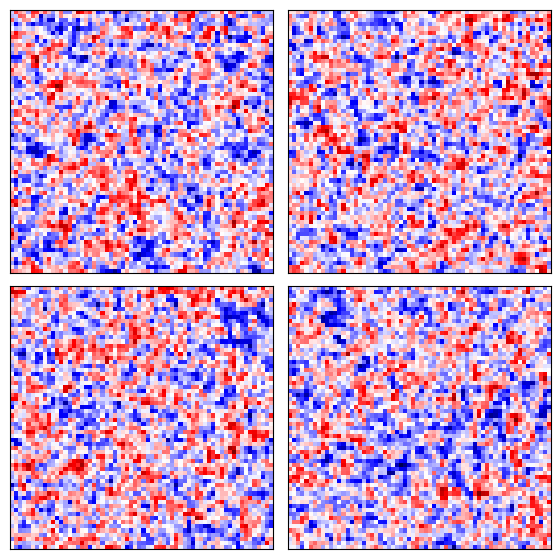

In [12]:
M = 5

key = jax.random.PRNGKey(1)
sks = jax.random.split(key, M)

for i in range(M):
    q_ph = gen_input_arr(sks[i],  cte, fm_cfg_phase)
    delta_ph = my_ifft(fmodel_phase.delta_in(q_ph), cte.INV_L3)
    delta_phases.append(delta_ph)

    q_wn = gen_input_arr(sks[i], cte, fm_cfg_wn)
    delta_wn = my_ifft(fmodel_wn.delta_in(q_wn), cte.INV_L3)
    delta_wns.append(delta_wn)

plot_cubes(delta_phases[:2] + delta_wns[:2], vlim=5e-2,  figsize=7)

pk_cube is not None, forcing no cross


(0.9, 1.1)

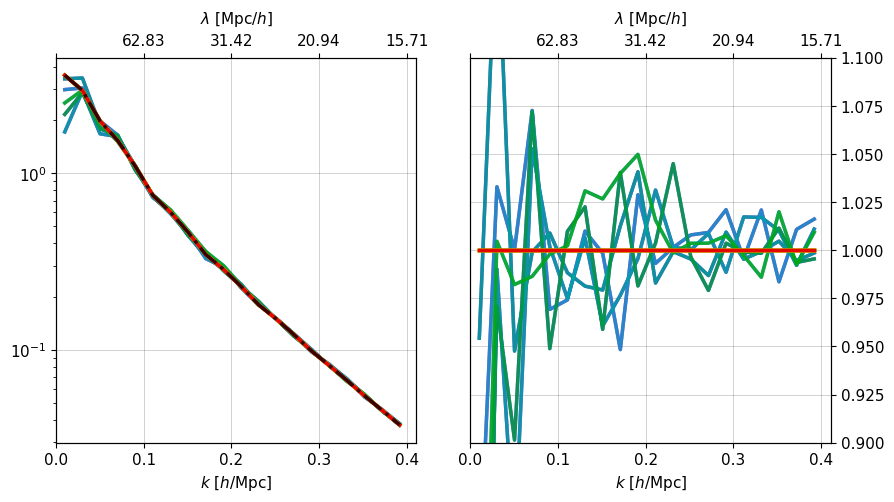

In [17]:
pk_cube = fm_cfg_phase.pow_spec
cs = ['k'] + ["b"] * M + ["r"] * M
fig, axs = compare_pow_spec(
    delta_wns + delta_phases,
    L,
    n_bins=20,
    pk_cube=pk_cube, 
    no_labels=True,
    sphere_only=True,
)
axs[1].set_ylim(0.9, 1.1)

In [20]:
jnp.mod(1.5, 1)

Array(0.5, dtype=float64, weak_type=True)

In [7]:
fact_sq = cte.L3**2 * cte.INV_N3

a = delta_ph * jnp.conj(delta_ph) * cte.INV_L3 * fact_sq
print(a.max())
print(pk_cube.max())

1.718154
3.9111588


In [ ]:



key = jax.random.PRNGKey(1)
q_ph = gen_input_arr(key, cte, fm_cfg)
z_unit = jnp.exp(1j * 2*jnp.pi *q_ph)
print('Q_SHAPE', q_ph.shape)
print('N^2 / 2 -2', N**2 // 2 -2 )

# a = make_rfft3_arr_of_phases(z_unit, N)

dc_plane_numbers = N**2 // 2 -2
a = make_rfft2_arr_from_phases(z_unit[:dc_plane_numbers], N)


